In [1]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score, classification_report
from xgboost import XGBRegressor
import matplotlib.pyplot as plt



In [2]:
# 加載數據
data = pd.read_csv('2023_09_2024_08_AQI_Weather_dataset.csv')

data.rename(columns={
    '測站氣壓(hPa)': 'station_pressure_hpa',
    '氣溫(℃)': 'temperature_c',
    '相對溼度(%)': 'relative_humidity',
    '風速(m/s)': 'wind_speed_m_s',
    '風向(360degree)': 'wind_direction_deg',
    #'最大瞬間風(m/s)': 'max_instant_wind_m_s',
    #'最大瞬間風風向(360degree)': 'max_instant_wind_direction_deg',
    '降水量(mm)': 'precipitation_mm'
}, inplace=True)

# 選擇需要的欄位
features = ['station_pressure_hpa', 'temperature_c', 'relative_humidity', 'wind_speed_m_s',
    'wind_direction_deg', 
    'precipitation_mm', 'pm2.5', 'pm10', 'so2', 'no2', 'nox', 'o3', 'co', 'o3_8hr',
    'co_8hr', 'pm2.5_avg', 'pm10_avg', 'so2_avg', 'no']
target = 'aqi'

# 將 AQI 轉為分級
def map_aqi_to_label(aqi):
    if aqi <= 50:
        return 0  # 良好
    elif aqi <= 100:
        return 1  # 普通
    elif aqi <= 150:
        return 2  # 對敏感族群不健康
    elif aqi <= 200:
        return 3  # 對所有族群不健康
    elif aqi <= 300:
        return 4  # 非常不健康
    else:
        return 5  # 危害

# 定義函數來計算分類指標
def calculate_classification_metrics(y_true, y_pred, label=""):
    # 將連續值轉換為分類標籤
    y_true_labels = np.array([map_aqi_to_label(aqi) for aqi in y_true.ravel()])
    y_pred_labels = np.array([map_aqi_to_label(aqi) for aqi in y_pred.ravel()])
    
    # 計算分類指標
    accuracy = accuracy_score(y_true_labels, y_pred_labels)
    recall = recall_score(y_true_labels, y_pred_labels, average="macro")
    f1 = f1_score(y_true_labels, y_pred_labels, average="macro")
    auroc = roc_auc_score(y_true_labels, y_pred_labels)
    
    print(f"{label} Accuracy: {accuracy:.3f}")
    print(f"{label} Recall (Macro): {recall:.3f}")
    print(f"{label} F1-Score (Macro): {f1:.3f}")
    print(f"{label} AUROC: {auroc:.3f}")

# 滑動窗口生成器
def create_windowed_data(data, features, target, input_steps, output_steps):
    for i in range(len(data) - input_steps - output_steps + 1):
        yield (
            data[features].iloc[i:i + input_steps].values.astype('float32'),
            data[target].iloc[i + input_steps:i + input_steps + output_steps].values.astype('float32'),
        )

def get_batch(generator, batch_size):
    X, y = zip(*(next(generator) for _ in range(batch_size)))
    return np.array(X), np.array(y)
    
# 短期
short_generator = create_windowed_data(data, features, target, input_steps=1, output_steps=1)
X_short, y_short = get_batch(short_generator, batch_size=1000)

# 中期
mid_generator = create_windowed_data(data, features, target, input_steps=24, output_steps=1)
X_mid, y_mid = get_batch(mid_generator, batch_size=1000)

# 長期
long_generator = create_windowed_data(data, features, target, input_steps=24, output_steps=24)
X_long, y_long = get_batch(long_generator, batch_size=1000)



In [3]:
# 分割與標準化
X_train_short, X_test_short, y_train_short, y_test_short= train_test_split(X_short, y_short, test_size=0.2, random_state=42)
X_train_mid, X_test_mid, y_train_mid, y_test_mid= train_test_split(X_mid, y_mid, test_size=0.2, random_state=42)
X_train_long, X_test_long, y_train_long, y_test_long= train_test_split(X_long, y_long, test_size=0.2, random_state=42)


In [4]:
# 初始化模型
linear_model_short = LinearRegression()
rf_model_short = RandomForestRegressor(n_estimators=100, random_state=42)
xgb_short = XGBRegressor()

# 訓練模型
X_train_flat_short = X_train_short.reshape(X_train_short.shape[0], -1)  # 展平特徵
start_time = time.time()
linear_model_short.fit(X_train_flat_short, y_train_short)
fit_time = time.time() - start_time
print(f"Linear Fit time: {fit_time:.4f} seconds")
start_time = time.time()
rf_model_short.fit(X_train_flat_short, y_train_short.ravel())
fit_time = time.time() - start_time
print(f"RF Fit time: {fit_time:.4f} seconds")
start_time = time.time()
xgb_short.fit(X_train_flat_short, y_train_short)
fit_time = time.time() - start_time
print(f"XGB Fit time: {fit_time:.4f} seconds")


# 測試模型
X_test_flat_short = X_test_short.reshape(X_test_short.shape[0], -1)
start_time = time.time()
y_pred_linear_short = linear_model_short.predict(X_test_flat_short)
predict_time = time.time() - start_time
print(f"Linear Predict time: {predict_time:.4f} seconds")
start_time = time.time()
y_pred_rf_short = rf_model_short.predict(X_test_flat_short)
predict_time = time.time() - start_time
print(f"RF Predict time: {predict_time:.4f} seconds")
start_time = time.time()
y_pred_xgb_short = xgb_short.predict(X_test_flat_short)
predict_time = time.time() - start_time
print(f"XGB Predict time: {predict_time:.4f} seconds")

# 評估
print("Linear Regression (Short-Term):")
print("MSE:", mean_squared_error(y_test_short, y_pred_linear_short))
print("MAE:", mean_absolute_error(y_test_short, y_pred_linear_short))

print("Random Forest (Short-Term):")
print("MSE:", mean_squared_error(y_test_short, y_pred_rf_short))
print("MAE:", mean_absolute_error(y_test_short, y_pred_rf_short))

print("XGBoost (Short-Term):")
print("MSE:", mean_squared_error(y_test_short, y_pred_xgb_short))
print("MAE:", mean_absolute_error(y_test_short, y_pred_xgb_short))

calculate_classification_metrics(y_test_short, y_pred_linear_short, "Linear Regression (Short)")
calculate_classification_metrics(y_test_short, y_pred_rf_short, "Random Forest (Short)")
calculate_classification_metrics(y_test_short, y_pred_xgb_short, "XGBoost (Short)")



Linear Fit time: 0.0010 seconds
RF Fit time: 0.5912 seconds
XGB Fit time: 0.2053 seconds
Linear Predict time: 0.0000 seconds
RF Predict time: 0.0048 seconds
XGB Predict time: 0.0010 seconds
Linear Regression (Short-Term):
MSE: 40.50388
MAE: 4.7878957
Random Forest (Short-Term):
MSE: 32.93445100000001
MAE: 3.8349000000000006
XGBoost (Short-Term):
MSE: 30.542835
MAE: 3.8766425
Linear Regression (Short) Accuracy: 0.885
Linear Regression (Short) Recall (Macro): 0.800
Linear Regression (Short) F1-Score (Macro): 0.831
Linear Regression (Short) AUROC: 0.800
Random Forest (Short) Accuracy: 0.895
Random Forest (Short) Recall (Macro): 0.813
Random Forest (Short) F1-Score (Macro): 0.846
Random Forest (Short) AUROC: 0.813
XGBoost (Short) Accuracy: 0.910
XGBoost (Short) Recall (Macro): 0.843
XGBoost (Short) F1-Score (Macro): 0.871
XGBoost (Short) AUROC: 0.843


In [5]:
# 初始化模型
linear_model_mid = LinearRegression()
rf_model_mid = RandomForestRegressor(n_estimators=100, random_state=42)
xgb_mid = XGBRegressor()

# 訓練模型
X_train_flat_mid = X_train_mid.reshape(X_train_mid.shape[0], -1)
start_time = time.time()
linear_model_mid.fit(X_train_flat_mid, y_train_mid)
fit_time = time.time() - start_time
print(f"Linear Fit time: {fit_time:.4f} seconds")
start_time = time.time()
rf_model_mid.fit(X_train_flat_mid, y_train_mid.ravel())
fit_time = time.time() - start_time
print(f"RF Fit time: {fit_time:.4f} seconds")
start_time = time.time()
xgb_mid.fit(X_train_flat_mid, y_train_mid)
fit_time = time.time() - start_time
print(f"XGB Fit time: {fit_time:.4f} seconds")

# 測試模型
X_test_flat_mid = X_test_mid.reshape(X_test_mid.shape[0], -1)
start_time = time.time()
y_pred_linear_mid = linear_model_mid.predict(X_test_flat_mid)
predict_time = time.time() - start_time
print(f"Linear Predict time: {predict_time:.4f} seconds")
start_time = time.time()
y_pred_rf_mid = rf_model_mid.predict(X_test_flat_mid)
predict_time = time.time() - start_time
print(f"RF Predict time: {predict_time:.4f} seconds")
start_time = time.time()
y_pred_xgb_mid = xgb_mid.predict(X_test_flat_mid)
predict_time = time.time() - start_time
print(f"XGB Predict time: {predict_time:.4f} seconds")

# 評估
print("Linear Regression (Mid-Term):")
print("MSE:", mean_squared_error(y_test_mid, y_pred_linear_mid))
print("MAE:", mean_absolute_error(y_test_mid, y_pred_linear_mid))

print("Random Forest (Mid-Term):")
print("MSE:", mean_squared_error(y_test_mid, y_pred_rf_mid))
print("MAE:", mean_absolute_error(y_test_mid, y_pred_rf_mid))

print("XGBoost (Mid-Term):")
print("MSE:", mean_squared_error(y_test_mid, y_pred_xgb_mid))
print("MAE:", mean_absolute_error(y_test_mid, y_pred_xgb_mid))

calculate_classification_metrics(y_test_mid, y_pred_linear_mid, "Linear Regression (Mid)")
calculate_classification_metrics(y_test_mid, y_pred_rf_mid, "Random Forest (Mid)")
calculate_classification_metrics(y_test_mid, y_pred_xgb_mid, "XGBoost (Mid)")


Linear Fit time: 0.2182 seconds
RF Fit time: 11.7821 seconds
XGB Fit time: 0.6530 seconds
Linear Predict time: 0.0000 seconds
RF Predict time: 0.0049 seconds
XGB Predict time: 0.0019 seconds
Linear Regression (Mid-Term):
MSE: 65.95129
MAE: 6.371096
Random Forest (Mid-Term):
MSE: 17.388911
MAE: 3.0825
XGBoost (Mid-Term):
MSE: 19.716738
MAE: 3.367179
Linear Regression (Mid) Accuracy: 0.835
Linear Regression (Mid) Recall (Macro): 0.747
Linear Regression (Mid) F1-Score (Macro): 0.754
Linear Regression (Mid) AUROC: 0.747
Random Forest (Mid) Accuracy: 0.940
Random Forest (Mid) Recall (Macro): 0.896
Random Forest (Mid) F1-Score (Macro): 0.910
Random Forest (Mid) AUROC: 0.896
XGBoost (Mid) Accuracy: 0.920
XGBoost (Mid) Recall (Macro): 0.859
XGBoost (Mid) F1-Score (Macro): 0.877
XGBoost (Mid) AUROC: 0.859


In [6]:
# 初始化模型
linear_model_long = LinearRegression()
rf_model_long = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42))
xgb_long = MultiOutputRegressor(XGBRegressor())

# 訓練模型
X_train_flat_long = X_train_long.reshape(X_train_long.shape[0], -1)
start_time = time.time()
linear_model_long.fit(X_train_flat_long, y_train_long)
fit_time = time.time() - start_time
print(f"Linear Fit time: {fit_time:.4f} seconds")
start_time = time.time()
rf_model_long.fit(X_train_flat_long, y_train_long)
fit_time = time.time() - start_time
print(f"RF Fit time: {fit_time:.4f} seconds")
start_time = time.time()
xgb_long.fit(X_train_flat_long, y_train_long)
fit_time = time.time() - start_time
print(f"XGB Fit time: {fit_time:.4f} seconds")

# 測試模型
X_test_flat_long = X_test_long.reshape(X_test_long.shape[0], -1)
start_time = time.time()
y_pred_linear_long = linear_model_long.predict(X_test_flat_long)
predict_time = time.time() - start_time
print(f"Linear Predict time: {predict_time:.4f} seconds")
start_time = time.time()
y_pred_rf_long = rf_model_long.predict(X_test_flat_long)
predict_time = time.time() - start_time
print(f"RF Predict time: {predict_time:.4f} seconds")
start_time = time.time()
y_pred_xgb_long = xgb_long.predict(X_test_flat_long)
predict_time = time.time() - start_time
print(f"XGB Predict time: {predict_time:.4f} seconds")

# 評估
print("Linear Regression (long-Term):")
print("MSE:", mean_squared_error(y_test_long, y_pred_linear_long))
print("MAE:", mean_absolute_error(y_test_long, y_pred_linear_long))

print("Random Forest (long-Term):")
print("MSE:", mean_squared_error(y_test_long, y_pred_rf_long))
print("MAE:", mean_absolute_error(y_test_long, y_pred_rf_long))

print("XGBoost (long-Term):")
print("MSE:", mean_squared_error(y_test_long, y_pred_xgb_long))
print("MAE:", mean_absolute_error(y_test_long, y_pred_xgb_long))

for model_name, y_pred_long in zip(
    ["Linear Regression (Long)", "Random Forest (Long)", "XGBoost (Long)"],
    [y_pred_linear_long, y_pred_rf_long, y_pred_xgb_long]
):
# 因為長期預測輸出為 24 小時的結果，需要逐時展平處理
    calculate_classification_metrics(y_test_long.ravel(), y_pred_long.ravel(), model_name)

Linear Fit time: 0.2837 seconds
RF Fit time: 323.3880 seconds
XGB Fit time: 18.3606 seconds
Linear Predict time: 0.0019 seconds
RF Predict time: 0.1325 seconds
XGB Predict time: 0.0309 seconds
Linear Regression (long-Term):
MSE: 236.63362
MAE: 11.684639
Random Forest (long-Term):
MSE: 54.34878277083334
MAE: 5.604152083333332
XGBoost (long-Term):
MSE: 48.657833
MAE: 5.2062345
Linear Regression (Long) Accuracy: 0.752
Linear Regression (Long) Recall (Macro): 0.432
Linear Regression (Long) F1-Score (Macro): 0.438
Linear Regression (Long) AUROC: 0.649
Random Forest (Long) Accuracy: 0.861
Random Forest (Long) Recall (Macro): 0.752
Random Forest (Long) F1-Score (Macro): 0.787
Random Forest (Long) AUROC: 0.752
XGBoost (Long) Accuracy: 0.871
XGBoost (Long) Recall (Macro): 0.783
XGBoost (Long) F1-Score (Macro): 0.812
XGBoost (Long) AUROC: 0.783


C:\Users\and01\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


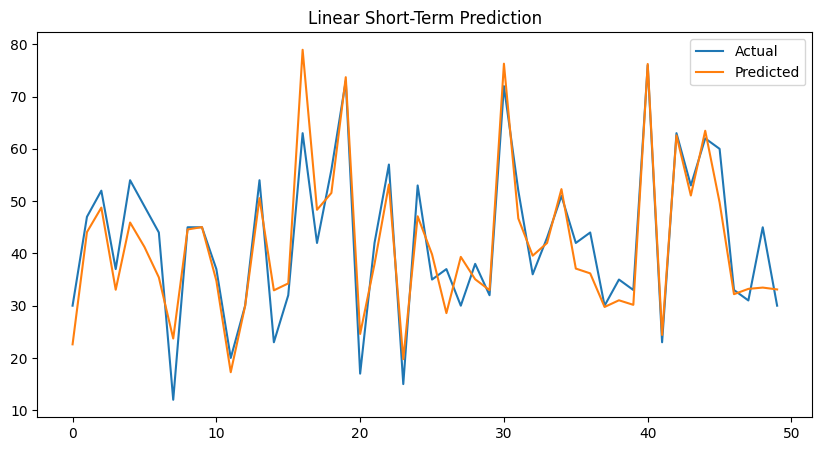

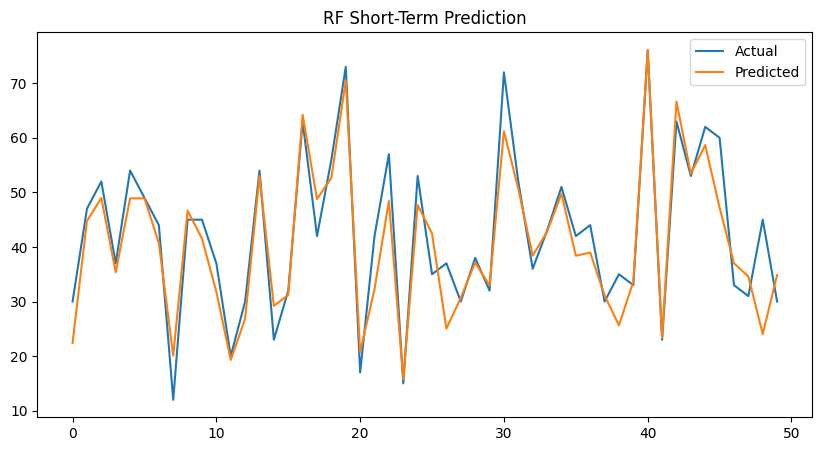

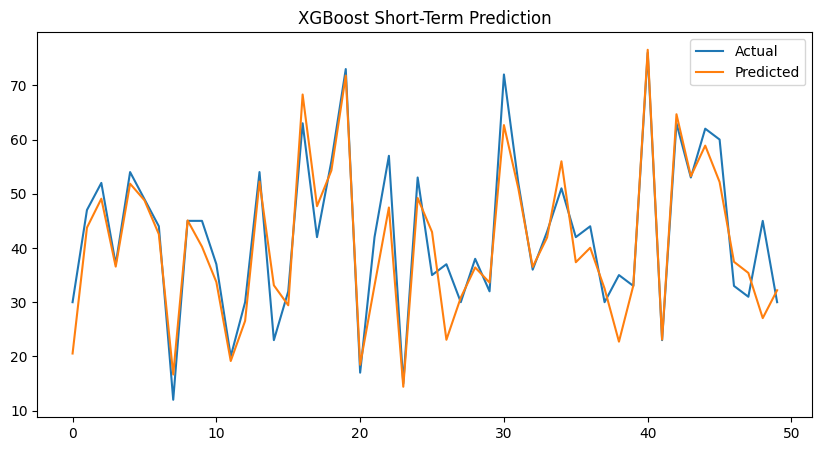

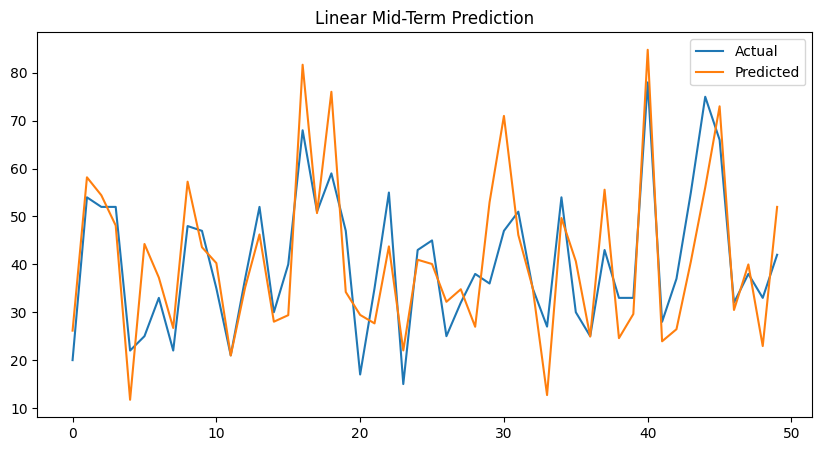

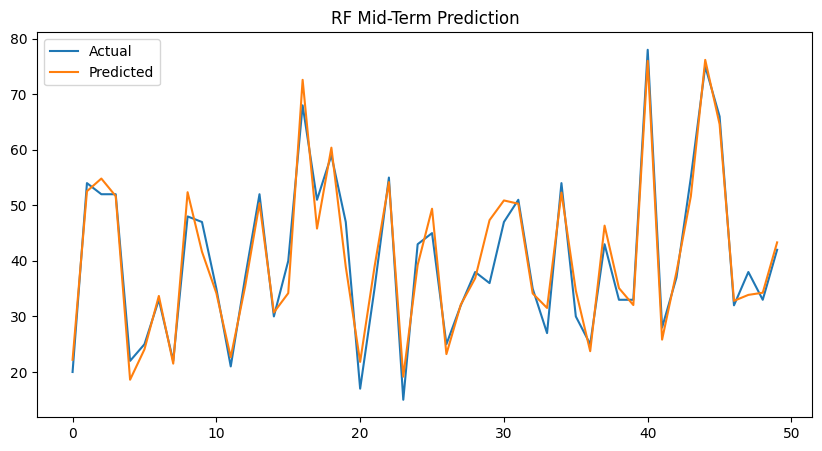

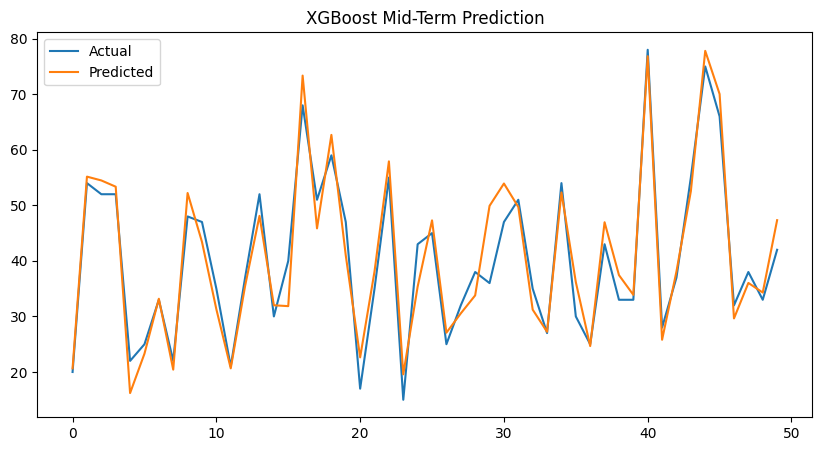

In [7]:
# 實際值與預測值比較（以短期為例）
plt.figure(figsize=(10, 5))
plt.plot(y_test_short[:50], label='Actual')
plt.plot(y_pred_linear_short[:50], label='Predicted')
plt.legend()
plt.title("Linear Short-Term Prediction")
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(y_test_short[:50], label='Actual')
plt.plot(y_pred_rf_short[:50], label='Predicted')
plt.legend()
plt.title("RF Short-Term Prediction")
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(y_test_short[:50], label='Actual')
plt.plot(y_pred_xgb_short[:50], label='Predicted')
plt.legend()
plt.title("XGBoost Short-Term Prediction")
plt.show()

# 實際值與預測值比較（以中期為例）
plt.figure(figsize=(10, 5))
plt.plot(y_test_mid[:50], label='Actual')
plt.plot(y_pred_linear_mid[:50], label='Predicted')
plt.legend()
plt.title("Linear Mid-Term Prediction")
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(y_test_mid[:50], label='Actual')
plt.plot(y_pred_rf_mid[:50], label='Predicted')
plt.legend()
plt.title("RF Mid-Term Prediction")
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(y_test_mid[:50], label='Actual')
plt.plot(y_pred_xgb_mid[:50], label='Predicted')
plt.legend()
plt.title("XGBoost Mid-Term Prediction")
plt.show()

